<a href="https://colab.research.google.com/github/schen304joseph/Project1/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [ ]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

drag=0.03
# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [ ]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0.,(GRAVITY_ACCEL-state[1] **2) * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity 
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [ ]:
class Dynamics1(nn.Module):

    def __init__(self):
        super(Dynamics1, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
               
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., (GRAVITY_ACCEL-0.1*state[1] **2)* FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [ ]:
class Dynamics2(nn.Module):

    def __init__(self):
        super(Dynamics2, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
               
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., (GRAVITY_ACCEL-1*state[1] **2)* FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [ ]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [ ]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [ ]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            #print('[%d] loss: %.3f' % (epoch + 1, loss))
            #self.visualize(self,epoch)
            data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
            x = data[:, 0]
            y = data[:, 1]
        
        return [x,y,loss]
        
        
    '''     
    def visualize(self,ii):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x[:,ii] = data[:, 0]
        y[:,ii] = data[:, 1]
        #plt.plot(x, y)
        #plt.show()
     '''

In [ ]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
xx,yy,loss1=o.train(40)  # solve the optimization problem

In [ ]:
d = Dynamics1()# define dynamics without drag
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
xx1,yy1,loss2=o.train(40)  # solve the optimization problem

loss with drag=1: 0.000 ; loss with drag=0.01: 0.000  ;loss without drag: 0.000


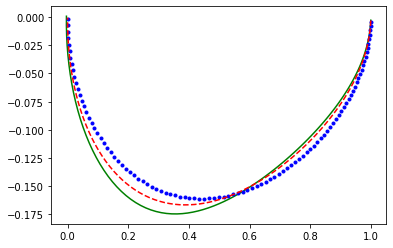

In [ ]:
d = Dynamics2()# define dynamics with drag=0.01
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
xx2,yy2,loss3=o.train(40)  # solve the optimization problem
print('loss with drag=1: %.3f' % loss1,'; loss with drag=0.01: %.3f '% loss3,';loss without drag: %.3f'% loss2)
plt.plot(xx, yy,'g-',xx1,yy1,'b.',xx2,yy2,'r--')
plt.show()


1. Problem Formulation:

  Motion of a falling object with air resistance (drag)

  F=ma=mg-D

  a=F/m=(mg-D)/m

  D/m=Cd*r*(v^2)*A/m*2 = α*v^2 (let α = Cd*r*A/2*m)

  As a result, a=g-α*v^2 (↓) (let g=0.12, α=1,0,0.01)

  Optimization problem frmulation:

  min ||X(T)||^2=d(T)^2+v(T)^2

  d(t+1)=d(t)+v(t)Δt

  v(t+1)=v(t)+a(t)Δt

  a(t)=0.12-α*v(t)^2  t=1.....,T-1 (T=40)

  x=[d(t);v(t)]

  loss function = x[0]^2+X[1]^2

2. Python code above
3. Result Analyzation: The result converge whe drag=1,0,0.01. Also, the loss=||x(T)||^2 approact to 0 with 40 iteration.

   Green line:α=1(with drag) Blue line:α=0(no drag) Red line:α=0.01(with drag)

   When the rocket is in the higher altitude (d(t)=1~0.4), since the air is thiner at this altitude, α=0.01 the drag has smaller effect on the rocket and the velocity of the rocket opposite to the ground is smaller. 
   
   However, when the rocket is at a lower altitude (d(t)=0.4~0), the air is thicker at this altitude. As a result, the drag has greater effect on the rocket. The rocket has higher velockty opposite to the ground as α=1

In [ ]:
from sympy import *
import matplotlib.pyplot as plt
import numpy as np
import math



cx=np.array([0,-0.35,0.39,0.4,-0.35])
cy=np.array([0,-0.4,0.39,-0.35,0.4])
r=np.array([1,0.17,0.12,0.18,0.13])
qd=np.array([0,0])
q=np.array([0.75,-0.6])

x=symbols('x')
y=symbols('y')
b=1

for i in range(0,len(cx)):
    b=b*((x-cx[i])**2+(y-cy[i])**2-r[i]**2)
    
b=-b
k=3.5

g=(x-qd[0])**2+(y-qd[1])**2
g=g/((g**k+b)**(1/k))

e=0.05
dt=0.01
p=np.array([])
p=np.concatenate((p,q))


while(((q[0]-qd[0])**2+(q[1]-qd[1])**2)**0.5>e):
    dx=diff(g,x)
    dy=diff(g,y)
    dxv=dx.evalf(subs={x:q[0],y:q[1]})
    dyv=dy.evalf(subs={x:q[0],y:q[1]})
    
    q[0]=q[0]-1/((q[0]-qd[0])**2+(q[1]-qd[1])**2)**0.5*dxv*dt
    q[1]=q[1]-1/((q[0]-qd[0])**2+(q[1]-qd[1])**2)**0.5*dyv*dt
    p=np.concatenate((p,q))
    

a=np.reshape(p,(-1,2))

fig = plt.figure() 
figure, axes = plt.subplots()

for i in range(0,len(cx)-1):
    draw_circle = plt.Circle((cx[i+1], cy[i+1]), r[i+1])
    plt.gca().add_patch(draw_circle)
    axes.set_aspect(1)
    #axes.add_artist(draw_circle)

plt.plot(a[:,0],a[:,1])

plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('robot trajectory for navigation function with 4 obstacles')

plt.show()

In [ ]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

kappa = 3.5
qd=np.array([0,0],dtype=np.complex)
center = np.array([[0, 0],
                   [-0.35, -0.4],
                   [0.39, 0.39],
                   [0.4, -0.35], 
                   [-0.35, 0.4]])
radius = np.array([[1],
                   [0.17],
                   [0.12], 
                   [0.18], 
                   [0.13]])
#beta_sphere = t.tensor([])
#x=t.arange(-1, 1, 0.01)
#y=t.arange(-1, 1,0.01)
#X,Y = t.meshgrid(x,y)
x1 = np.arange(start=0, stop=1, step=0.01)
x2 = np.arange(start=0, stop=1, step=0.01)
Xm, Ym = np.meshgrid(x1, x2)

In [ ]:
def Obstacle (x,y):
  beta_sphere=np.zeros(len(radius))
  #print(beta_sphere)
  beta_sphere[0]=(radius[0]**2-(x-center[0][0])**2+(y-center[0][1])**2)
  #print(beta_sphere)
  i=1
  for i in range (len(radius)):
     beta_sphere[i]=((x-center[i,0])**2+(y-center[i,1])**2)-(radius[i,0])**2 
  #print(beta_sphere)
  beta_prod = np.ones(len(beta_sphere))
  i=1
  for i in range (len(beta_sphere)):
    beta_prod = beta_prod*beta_sphere[i]

  gamma = (x-qd[0])**2+(y-qd[1])**2
  nav_sys= gamma/(gamma**kappa+beta_prod)**(1/kappa)
  return nav_sys

print(Obstacle(0.2,0.17))


def navigation ():
  gamma = t.tensor((xy[0]-qd[0])**2+(xy[1]-qd[1])**2)
  nav_sys = t.tensor(gamma/(gamma**kappa+beta_prod)**(1/kappa))
  return nav_sys

[0.21457846-0.26907288j 0.21457846-0.26907288j 0.21457846-0.26907288j
 0.21457846-0.26907288j 0.21457846-0.26907288j]


In [ ]:
def loss_fun(x,y)
  cord = Variable(x, requires_grad=True)
  a=0.001
  for i in range (10)
     loss = 

In [ ]:
gamma = ((X-qd[0,0])**2+(Y-qd[0,1]**2)
nav = (gamma / (gamma**kappa+beta_prob)**(1/kappa))
fig = plt.figure()
plt.title('Contour plot')
contours=plt.contourf(X, Y, nav,cmap='viridis')
plt.clabel(contours, inline=True, fontsize=15)
plt.colorbar()

SyntaxError: ignored